In [137]:
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# --- local package ------------------------------------------------------------
sys.path.append(os.path.abspath('..'))
from mlmc import C_MLMC, WeakConvergenceError
from mlmc.bs_level_terminal import MilsteinBSLevelFunction, bs_exact_call
from mlmc.payoffs import call_payoff

In [138]:
# parameters
S0, K = 95.0, 100.0
r, sigma  = 0.05, 0.1
T     = 1.0

# Target tolerances for demonstration
EPS = [0.2, 0.1, 0.05, 0.025,0.025/2,0.025/4,]


In [139]:
#  parameters
S0, K, r, sigma, T = 100.0, 100.0, 0.05, 0.20, 1.0
exact             = bs_exact_call(S0, K, r, sigma, T)  
disc              = math.exp(-r * T)

In [140]:
print('Exact price of this option: ',exact)

Exact price of this option:  10.450583572185565


In [141]:
payoff   = lambda S: call_payoff(S, K)
level_fn = MilsteinBSLevelFunction(S0, r, sigma, T, payoff,verbose=False).simulate

In [142]:
def feature_fn(detail):
    S_fine = detail["S_fine"]

    if "S_coarse" in detail:
        S_coarse = detail["S_coarse"]
        return np.array([
            S_fine,                  
            S_fine - S_coarse      
        ])
    else:
        return np.array([
            S_fine
        ])

In [143]:
# C-MLMC object
cmlmc_obj = C_MLMC(
    sde_step_fn=level_fn,
    feature_fn=feature_fn,
    Lmin=2,
    Lmax=20,
    n_clusters=3,
    N0=200,
    scale_features=True
)

In [144]:
# Run C-MLMC
records = []

for eps in EPS:
    rec = {"epsilon": eps}
    try:
        t0 = time.perf_counter()
        price, Nl, Cl, total_cost = cmlmc_obj.estimate(eps)
        rec.update({
            "price": price,
            "time_s": time.perf_counter() - t0,
            "total_cost": total_cost,
            "N_per_level": Nl.copy()
        })
    except WeakConvergenceError as err:
        rec.update({
            "price": np.nan,
            "time_s": np.nan,
            "total_cost": np.nan,
            "N_per_level": None,
            "error": str(err)
        })
    records.append(rec)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [145]:
# exact price
print(f"Exact price: {exact}")

# results
df = pd.DataFrame(records)

Nl_df = pd.DataFrame(df["N_per_level"].tolist(), index=df.index).add_prefix("N_l_")
out = pd.concat([df.drop(columns="N_per_level"), Nl_df], axis=1)
out = out.fillna(0)
display(out)


Exact price: 10.450583572185565


,epsilon,price,time_s,total_cost,N_l_0,N_l_1,N_l_2,N_l_3,N_l_4,N_l_5,N_l_6,N_l_7,N_l_8,N_l_9,N_l_10,N_l_11,N_l_12
0,0.20000,10.112820,0.017864,58044.0,7244,200,200,200,200,200,200,200,0.0,0.0,0.0,0.0,0.0
1,0.10000,10.368133,0.023671,84271.0,30671,468,232,200,200,200,200,200,0.0,0.0,0.0,0.0,0.0
2,0.05000,10.347326,0.089620,411963.0,135963,2169,955,246,200,200,200,200,200.0,200.0,0.0,0.0,0.0
3,0.02500,10.417189,0.307595,1465685.0,592085,8919,4209,425,327,206,200,200,200.0,200.0,200.0,0.0,0.0
4,0.01250,10.387365,0.868379,4183318.0,2220918,39427,15695,2136,757,399,210,200,200.0,200.0,200.0,200.0,0.0
5,0.00625,10.419467,2.726188,13176574.0,8570174,159614,59078,14632,4922,880,412,251,200.0,200.0,200.0,200.0,200.0


<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_82252/1270088141.py:10: SyntaxWarning: invalid escape sequence '\e'
  axs[0].set_xlabel("Tolérance $\epsilon$")
/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_82252/1270088141.py:18: SyntaxWarning: invalid escape sequence '\e'
  axs[1].loglog(out["epsilon"], out["epsilon"]**-2, '--', label='Référence O($\epsilon^{-2}$)')
/var/folders/bl/500x18v50xz3zwzx4p286wqw0000gn/T/ipykernel_82252/1270088141.py:19: SyntaxWarning: invalid escape sequence '\e'
  axs[1].loglog(out["epsilon"], out["epsilon"]**-3, '--', label='Référe

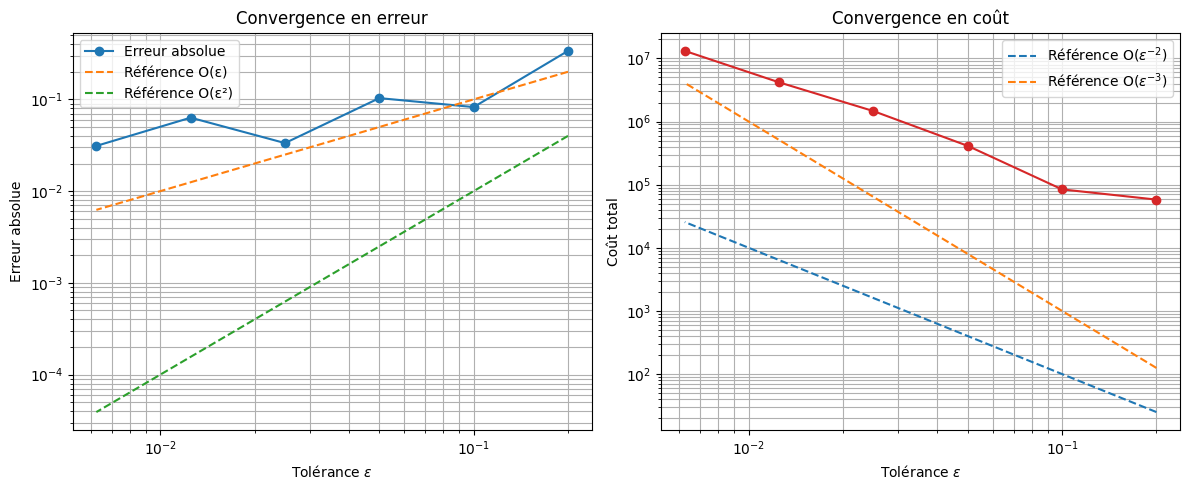

In [146]:
out["abs_error"] = np.abs(out["price"] - exact)

# --------- Plot ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Erreur vs epsilon
axs[0].loglog(out["epsilon"], out["abs_error"], 'o-', label='Erreur absolue')
axs[0].loglog(out["epsilon"], out["epsilon"], '--', label='Référence O(ε)')
axs[0].loglog(out["epsilon"], out["epsilon"]**2, '--', label='Référence O(ε²)')
axs[0].set_xlabel("Tolérance $\epsilon$")
axs[0].set_ylabel("Erreur absolue")
axs[0].set_title("Convergence en erreur")
axs[0].legend()
axs[0].grid(True, which="both")

# Coût vs epsilon
axs[1].loglog(out["epsilon"], out["total_cost"], 'o-', color='tab:red')
axs[1].loglog(out["epsilon"], out["epsilon"]**-2, '--', label='Référence O($\epsilon^{-2}$)')
axs[1].loglog(out["epsilon"], out["epsilon"]**-3, '--', label='Référence O($\epsilon^{-3}$)')
axs[1].set_xlabel("Tolérance $\epsilon$")
axs[1].set_ylabel("Coût total")
axs[1].set_title("Convergence en coût")
axs[1].legend()
axs[1].grid(True, which="both")

plt.tight_layout()
plt.show()

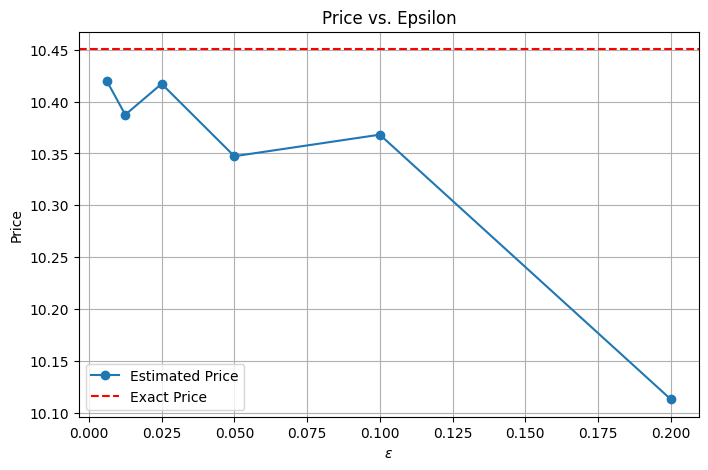

In [149]:
plt.figure(figsize=(8,5))
plt.plot(out['epsilon'], out['price'], marker='o', linestyle='-', label='Estimated Price')

# Ligne horizontale du prix exact
plt.axhline(y=exact, color='red', linestyle='--', label='Exact Price')

plt.xlabel(r'$\varepsilon$')
plt.ylabel('Price')
plt.title('Price vs. Epsilon')
plt.legend()
plt.grid(True)
plt.show()